In [9]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patchworklib as pw
import seaborn as sns
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.style.use("papers")
pw.overwrite_axisgrid()

FOLDER = "../../results/20220331_random_data_stuff_200subjects_20channels_4states/"

In [53]:
data = pd.read_csv(
    os.path.join(FOLDER, "data_and_segmentation.csv"), index_col=[0, 1]
).rename(columns={"kmeans": "mod. K-Means"})
stats = pd.read_csv(os.path.join(FOLDER, "basic_stats.csv"), index_col=0)
dynstats = pd.read_csv(os.path.join(FOLDER, "dyn_stats.csv"), index_col=0)
maps = xr.open_dataarray(os.path.join(FOLDER, "topomaps.nc"))

In [37]:
COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]
data_for_corr = data.iloc[:, 20:].loc[:, COLUMNS_ORDER]
data_for_corr = data_for_corr.groupby("subject").corr("spearman").unstack()

<AxesSubplot:>

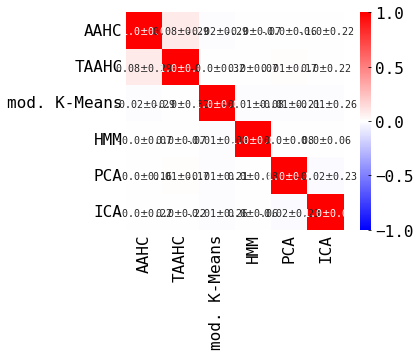

In [44]:
segm_mean = (
    data_for_corr.mean()
    .reset_index()
    .pivot(index="level_0", columns="level_1")
    .loc[COLUMNS_ORDER, (0, COLUMNS_ORDER)]
)
segm_mean.index.name = ""
segm_mean.columns = segm_mean.columns.get_level_values(1)
segm_mean.columns.name = ""

segm_std = (
    data_for_corr.std()
    .reset_index()
    .pivot(index="level_0", columns="level_1")
    .loc[COLUMNS_ORDER, (0, COLUMNS_ORDER)]
)
segm_std.index.name = ""
segm_std.columns = segm_std.columns.get_level_values(1)
segm_std.columns.name = ""

ax = plt.subplot(111)
sns.heatmap(
    segm_mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=segm_mean.round(2).astype(str) + "$\pm$" + segm_std.round(2).astype(str),
    fmt="",
)
# mean = prep.
# std = prep.std(ddof=1).reset_index().pivot(index="level_0", columns="level_1")

In [ ]:
# rcorrs = data[data.columns[3:]].corr("spearman")
# np.fill_diagonal(rcorrs.values, np.nan)
# g7 = pw.Brick("ax54", figsize=(3, 3))
# sns.heatmap(
#     rcorrs,
#     square=True,
#     vmax=1.0,
#     vmin=-1,
#     cmap="bwr",
#     annot=data[data.columns[3:]].rcorr("spearman", padjust="fdr_by", decimals=2),
#     fmt="",
#     annot_kws={"fontsize": 14},
#     ax=g7,
# )
# g7.set_title("Segmentation // Spearman")
# # g7 = pw.load_seaborngrid(g)
# display(data[data.columns[3:]].rcorr("spearman", padjust="fdr_by"))

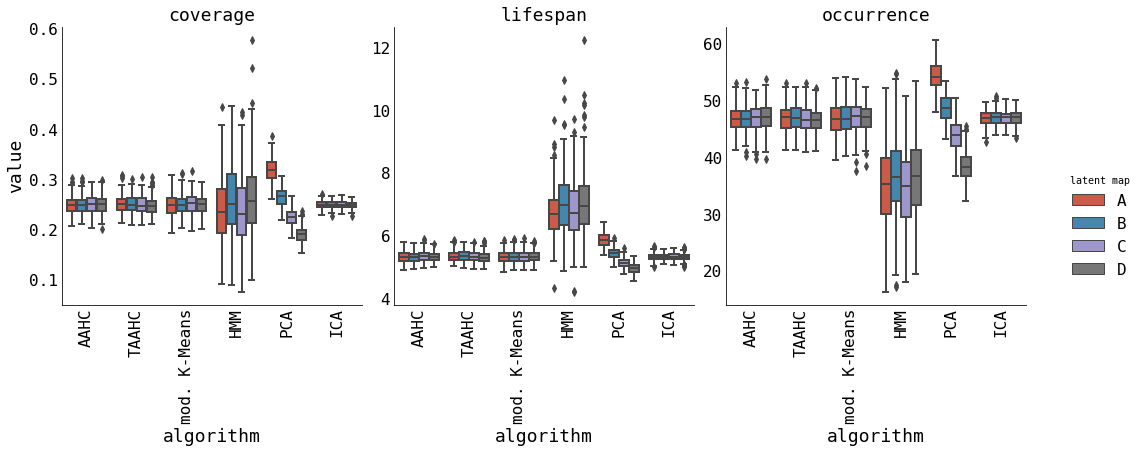

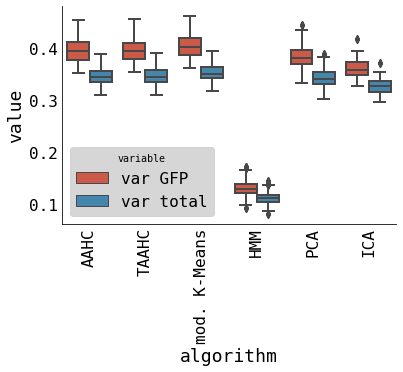

In [65]:
# stats = (
#     stats.replace({"kmeans": "mod. K-Means"}).rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
#     .set_index("algorithm")
#     .loc[COLUMNS_ORDER]
#     .reset_index()
# )
stats_melt = stats.melt(
    id_vars=["algorithm", "latent map"],
    value_vars=["coverage", "lifespan", "occurrence"],
)
g = sns.catplot(
    data=stats_melt,
    x="algorithm",
    y="value",
    hue="latent map",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
plt.show()
g = sns.boxplot(
    data=stats.melt(id_vars="algorithm", value_vars=["var GFP", "var total"]),
    x="algorithm",
    y="value",
    hue="variable",
)
sns.despine(ax=g)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)
plt.show()
# g8 = pw.load_seaborngrid(g)
# g8.savefig(quick=True)

In [72]:
dynstats

,algorithm,subject,mixing time,entropy,max entropy,entropy rate,MC entropy rate,AIF 1st peak
0,PCA,rnd_subject_4,1.024593,1.382002,1.386294,1.244917,1.992197,68.0
1,ICA,rnd_subject_4,1.000046,1.386185,1.386294,1.247124,1.997588,40.0
2,kmeans,rnd_subject_4,1.007490,1.384587,1.386294,1.243186,1.993129,36.0
3,AAHC,rnd_subject_4,1.036421,1.385486,1.386294,1.243490,1.995976,52.0
4,TAAHC,rnd_subject_4,0.990172,1.384778,1.386294,1.237117,1.994515,44.0
...,...,...,...,...,...,...,...,...
1,ICA,rnd_subject_199,0.994465,1.385618,1.386294,1.238401,1.997544,52.0
2,kmeans,rnd_subject_199,1.005161,1.385790,1.386294,1.243437,1.997442,48.0
3,AAHC,rnd_subject_199,1.018589,1.383973,1.386294,1.244452,1.995503,56.0
4,TAAHC,rnd_subject_199,1.027475,1.384960,1.386294,1.237696,1.996579,40.0


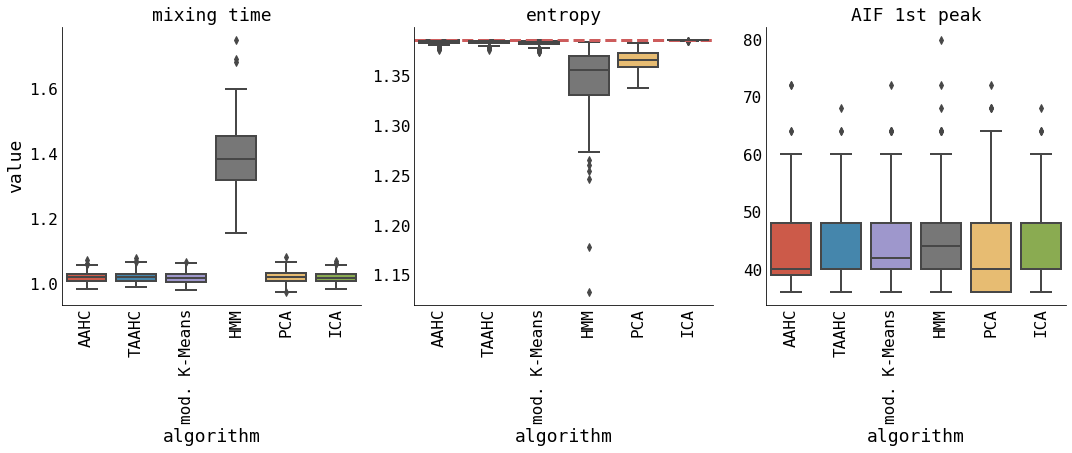

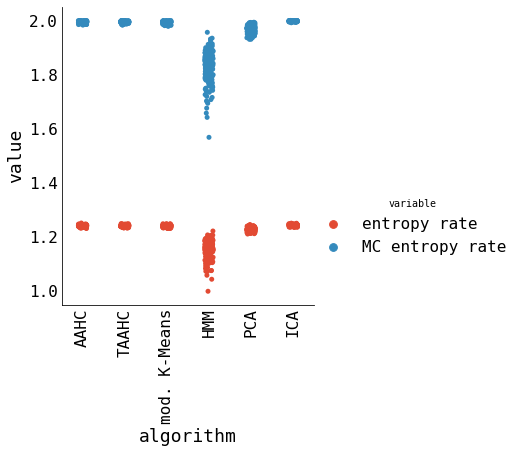

In [78]:
dynstats_melt = (
    dynstats.replace({"kmeans": "mod. K-Means"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["mixing time", "entropy", "AIF 1st peak"],
    )
)
g = sns.catplot(
    data=dynstats_melt,
    x="algorithm",
    y="value",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0, 1].axhline(
    dynstats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
plt.show()

g = sns.catplot(
    data=dynstats.replace({"kmeans": "mod. K-Means"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["entropy rate", "MC entropy rate"],
    ),
    x="algorithm",
    y="value",
    hue="variable",
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)
plt.show()

In [80]:
all_corrs = []
for alg1 in maps["algorithm"]:
    for alg2 in maps["algorithm"]:
        for map1 in maps["latent map"]:
            for map2 in maps["latent map"]:
                corrs = (
                    xr.corr(
                        maps.sel({"algorithm": alg1, "latent map": map1}),
                        maps.sel({"algorithm": alg2, "latent map": map2}),
                        dim="channels",
                    )
                    .assign_coords(
                        {"alg1": alg1, "alg2": alg2, "map1": map1, "map2": map2}
                    )
                    .expand_dims(["alg1", "alg2", "map1", "map2"])
                )
                all_corrs.append(corrs)
all_corrs = np.abs(xr.combine_by_coords(all_corrs))

In [81]:
mean = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .mean("subject")
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
std = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .std("subject", ddof=1)
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
mean.round(3).astype(str) + " $\pm$ " + std.round(3).astype(str)

0                                        \
alg2                 AAHC                HMM                ICA   
alg1                                                              
AAHC        1.0 $\pm$ 0.0  0.517 $\pm$ 0.114  0.857 $\pm$ 0.072   
HMM     0.517 $\pm$ 0.114      1.0 $\pm$ 0.0  0.515 $\pm$ 0.097   
ICA     0.857 $\pm$ 0.072  0.515 $\pm$ 0.097      1.0 $\pm$ 0.0   
PCA     0.901 $\pm$ 0.051   0.52 $\pm$ 0.104  0.878 $\pm$ 0.065   
TAAHC   0.953 $\pm$ 0.038  0.513 $\pm$ 0.105  0.859 $\pm$ 0.074   
kmeans   0.947 $\pm$ 0.04  0.515 $\pm$ 0.105  0.875 $\pm$ 0.076   

                                                                 
alg2                  PCA              TAAHC             kmeans  
alg1                                                             
AAHC    0.901 $\pm$ 0.051  0.953 $\pm$ 0.038   0.947 $\pm$ 0.04  
HMM      0.52 $\pm$ 0.104  0.513 $\pm$ 0.105  0.515 $\pm$ 0.105  
ICA     0.878 $\pm$ 0.065  0.859 $\pm$ 0.074  0.875 $\pm$ 0.076  
PCA         1.0 $\pm$ 0.0  0.901 $\pm$ 0.055    0.9 $\pm$ 0.059  
TAAHC   0.901 $\pm$ 0.055      1.0 $\pm$ 0.0    0.95 $\pm$ 0.04  
kmeans    0.9 $\pm$ 0.059    0.95 $\pm$ 0.04      1.0 $\pm$ 0.0

In [8]:
mean = (
    all_corrs.where(all_corrs.alg1 == all_corrs.alg2, drop=True)
    .where(all_corrs.map1 != all_corrs.map2)
    .max(["map1", "map2"])
    .mean("subject")
    .to_series()
    .dropna()
    .reset_index()
    .drop("alg2", axis=1)
    .rename(columns={"alg1": "algorithm", 0: "rho"})
    .set_index("algorithm")
)
std = (
    all_corrs.where(all_corrs.alg1 == all_corrs.alg2, drop=True)
    .where(all_corrs.map1 != all_corrs.map2)
    .max(["map1", "map2"])
    .std("subject", ddof=1)
    .to_series()
    .dropna()
    .reset_index()
    .drop("alg2", axis=1)
    .rename(columns={"alg1": "algorithm", 0: "rho"})
    .set_index("algorithm")
)
mean.round(3).astype(str) + " $\pm$ " + std.round(3).astype(str)

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


,rho
algorithm,
AAHC,0.507 $\pm$ 0.096
HMM,0.559 $\pm$ 0.078
ICA,0.185 $\pm$ 0.06
PCA,0.063 $\pm$ 0.045
TAAHC,0.491 $\pm$ 0.095
kmeans,0.425 $\pm$ 0.098


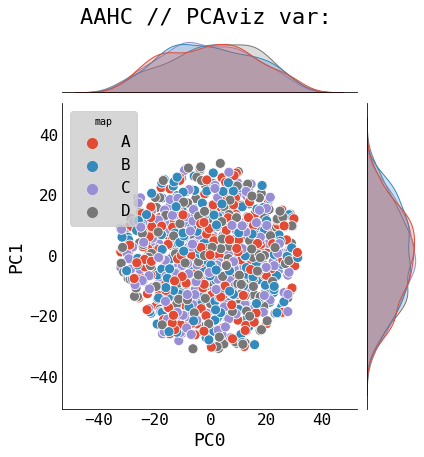

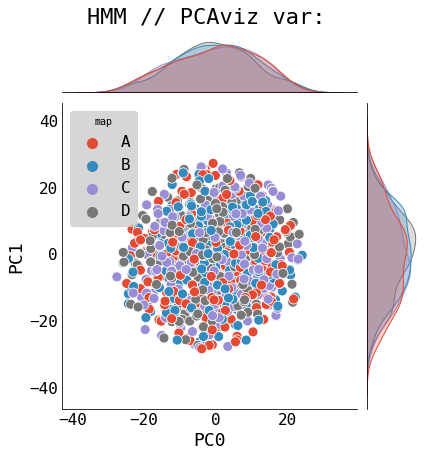

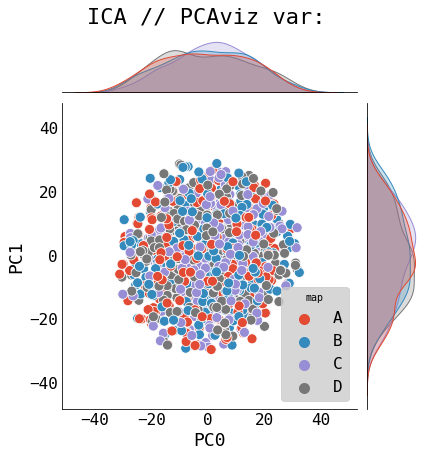

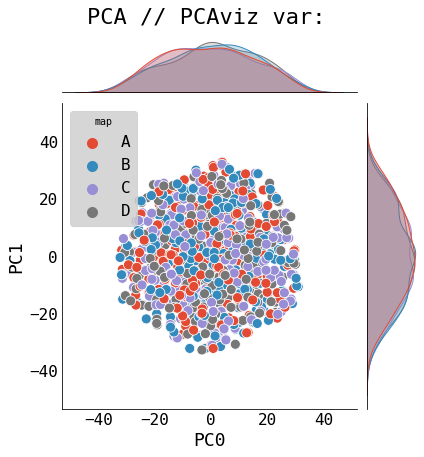

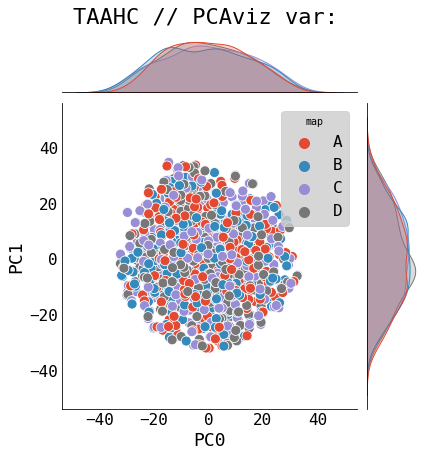

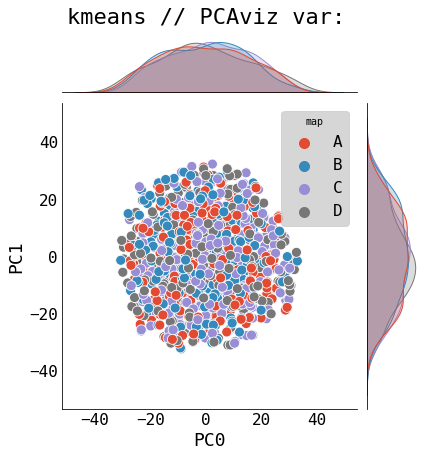

In [11]:
for decomp in maps["algorithm"]:
    # pca = PCA(n_components=2)
    # pcs = pca.fit_transform(
    #     maps.stack(samples=("subject", "latent map"))
    #     .sel({"algorithm": decomp})
    #     .values.T
    # )
    tsne = TSNE(n_components=2)
    pcs = tsne.fit_transform(
        maps.stack(samples=("subject", "latent map"))
        .sel({"algorithm": decomp})
        .values.T
    )
    low_dim = pd.DataFrame(pcs, columns=["PC0", "PC1"])
    low_dim["map"] = maps.stack(samples=("subject", "latent map")).sel(
        {"algorithm": decomp}
    )["latent map"]
    g = sns.jointplot(data=low_dim, x="PC0", y="PC1", hue="map")
    g.fig.suptitle(
        f"{decomp.values} // PCAviz var: ",  # {pca.explained_variance_ratio_.sum():.1%}",
        y=1.05,
    )
    plt.show()